In [2]:
# Instalación de librerías necesarias
!pip install yfinance --quiet
!pip install PyPortfolioOpt --quiet
!pip show PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.4 MB/s eta 0:00:00
Name: pyportfolioopt
Version: 1.5.6
Summary: Financial portfolio optimization in python
Home-page: https://github.com/robertmartin8/PyPortfolioOpt
Author: Robert Andrew Martin
Author-email: martin.robertandrew@gmail.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: cvxpy, ecos, numpy, pandas, plotly, scipy
Required-by: 


In [3]:
# Importación de librerías
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_covariance
import matplotlib.pyplot as plt


In [4]:
# Tickers fijos de prueba
tickers = ["^GSPC", "F", "AAPL", "GC=F"]

In [5]:
# Descargar datos
data = yf.download(tickers, start="2024-01-01", end="2025-06-01")["Close"]
returns = data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
<ipython-input-5-2576878918>:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [6]:
# Parámetros del mercado
cov_matrix = risk_models.sample_cov(data)
market_caps = pd.Series([1/len(tickers)] * len(tickers), index=tickers)
risk_aversion = 2.5
market_prior = market_implied_prior_returns(market_caps, risk_aversion, cov_matrix)

In [20]:
P = np.array([
    [0, -1, 0, 1],  # Relative view: AAPL - MSFT
    [0, 0, 1, 0],
     [1, 0, 0, 0], # Absolute view: MSFT
])

# Q vector: expected return differences for each view
Q = np.array([
    0.09,  # Expected difference of 0.02 for AAPL - MSFT
    0.05,  # Expected return of 0.05 for MSFT
    0.01
])



In [21]:
bl = BlackLittermanModel(
    cov_matrix=cov_matrix,
    pi=market_prior,
    P=P,         # Pass the P matrix
    Q=Q,         # Pass the Q vector
    tau=0.05     # Optional: specify tau (scaling factor for the covariance of the prior)
)
bl_returns = bl.bl_returns()

In [22]:
# Optimización
ef = EfficientFrontier(bl_returns, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)

Expected annual return: 4.2%
Annual volatility: 13.0%
Sharpe Ratio: 0.32


(np.float64(0.04168462155207922),
 np.float64(0.1297819281148696),
 np.float64(0.32118972308058397))

In [23]:
# Mostrar resultados
print("Ponderaciones óptimas (Black-Litterman):")
for ticker, weight in cleaned_weights.items():
    print(f"{ticker}: {weight:.2%}")

Ponderaciones óptimas (Black-Litterman):
AAPL: 4.50%
F: 0.00%
GC=F: 44.95%
^GSPC: 50.55%


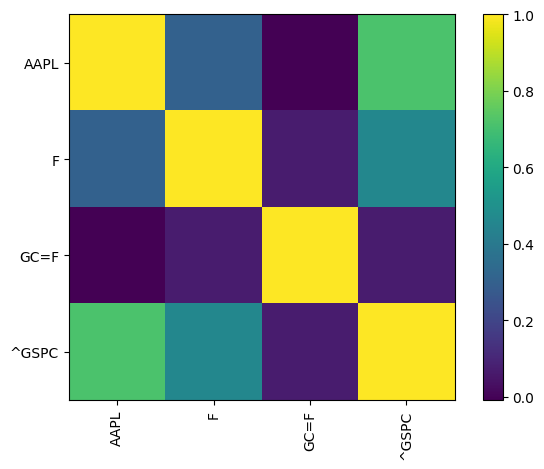

In [11]:
# Visualización
plot_covariance(cov_matrix, plot_correlation=True)
plt.show()